# Initial Configs

In [33]:
# autoreload reloads modules automatically before entering the execution of code typed at the IPython prompt
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import sys
from dotenv import find_dotenv, load_dotenv
import os

# find .env automagically by walking up directories until it's found, then
# load up the .env entries as environment variables
load_dotenv(find_dotenv()) 


# Adds higher directory to python modules path.
sys.path.append("..") 

# Imports

In [245]:
# Plots
import seaborn as sns
import matplotlib.pyplot as plt

# Data
import pandas as pd
import numpy as np
import swifter
import feather as fe
import csv

# Preprocessing and Pipeline
import preprocessor as p
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.preprocessing import StandardScaler, MaxAbsScaler

# Modeling
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.linear_model import LinearRegression
from pycaret.regression import *
from hyperopt import hp
from hyperopt.pyll.stochastic import sample
from hyperopt import tpe
from hyperopt import Trials
from hyperopt import fmin

# Evaluation of the model
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import (r2_score, mean_squared_error, mean_squared_log_error, median_absolute_error)

# Explain
import eli5

# Utils
import time
import random
from hyperopt import STATUS_OK
from timeit import default_timer as timer

# Config

In [244]:
pd.set_option('display.max_colwidth', 255)
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.4f}'.format

# optimization algorithm
tpe_algorithm = tpe.suggest

# Keep track of results
bayes_trials = Trials()

# File to save first results
out_file = '../models/logging/gbm_trials.csv'
of_connection = open(out_file, 'w')
writer = csv.writer(of_connection)

# Write the headers to the file
writer.writerow(['loss', 'params', 'iteration', 'estimators', 'train_time'])
of_connection.close()



In [246]:
%%capture

# Global variable
global  ITERATION

ITERATION = 0

# Load data

In [182]:
df_train = pd.read_csv("../data/raw/train.csv")
df_test = pd.read_csv("../data/raw/test.csv")

In [183]:
df_train

,Unnamed: 0,NU_INSCRICAO,NU_ANO,CO_MUNICIPIO_RESIDENCIA,NO_MUNICIPIO_RESIDENCIA,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,CO_MUNICIPIO_NASCIMENTO,NO_MUNICIPIO_NASCIMENTO,CO_UF_NASCIMENTO,SG_UF_NASCIMENTO,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,IN_TREINEIRO,CO_ESCOLA,CO_MUNICIPIO_ESC,NO_MUNICIPIO_ESC,CO_UF_ESC,SG_UF_ESC,TP_DEPENDENCIA_ADM_ESC,TP_LOCALIZACAO_ESC,TP_SIT_FUNC_ESC,IN_BAIXA_VISAO,IN_CEGUEIRA,IN_SURDEZ,IN_DEFICIENCIA_AUDITIVA,IN_SURDO_CEGUEIRA,IN_DEFICIENCIA_FISICA,IN_DEFICIENCIA_MENTAL,IN_DEFICIT_ATENCAO,IN_DISLEXIA,IN_DISCALCULIA,IN_AUTISMO,IN_VISAO_MONOCULAR,IN_OUTRA_DEF,IN_SABATISTA,IN_GESTANTE,IN_LACTANTE,IN_IDOSO,IN_ESTUDA_CLASSE_HOSPITALAR,IN_SEM_RECURSO,IN_BRAILLE,IN_AMPLIADA_24,IN_AMPLIADA_18,IN_LEDOR,IN_ACESSO,IN_TRANSCRICAO,IN_LIBRAS,IN_LEITURA_LABIAL,IN_MESA_CADEIRA_RODAS,IN_MESA_CADEIRA_SEPARADA,IN_APOIO_PERNA,IN_GUIA_INTERPRETE,IN_MACA,IN_COMPUTADOR,IN_CADEIRA_ESPECIAL,IN_CADEIRA_CANHOTO,IN_CADEIRA_ACOLCHOADA,IN_PROVA_DEITADO,IN_MOBILIARIO_OBESO,IN_LAMINA_OVERLAY,IN_PROTETOR_AURICULAR,IN_MEDIDOR_GLICOSE,IN_MAQUINA_BRAILE,IN_SOROBAN,IN_MARCA_PASSO,IN_SONDA,IN_MEDICAMENTOS,IN_SALA_INDIVIDUAL,IN_SALA_ESPECIAL,IN_SALA_ACOMPANHANTE,IN_MOBILIARIO_ESPECIFICO,IN_MATERIAL_ESPECIFICO,IN_NOME_SOCIAL,IN_CERTIFICADO,NO_ENTIDADE_CERTIFICACAO,CO_UF_ENTIDADE_CERTIFICACAO,SG_UF_ENTIDADE_CERTIFICACAO,CO_MUNICIPIO_PROVA,NO_MUNICIPIO_PROVA,CO_UF_PROVA,SG_UF_PROVA,TP_PRESENCA_CN,TP_PRESENCA_CH,TP_PRESENCA_LC,TP_PRESENCA_MT,CO_PROVA_CN,CO_PROVA_CH,CO_PROVA_LC,CO_PROVA_MT,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,TX_RESPOSTAS_CN,TX_RESPOSTAS_CH,TX_RESPOSTAS_LC,TX_RESPOSTAS_MT,TP_LINGUA,TX_GABARITO_CN,TX_GABARITO_CH,TX_GABARITO_LC,TX_GABARITO_MT,TP_STATUS_REDACAO,NU_NOTA_COMP1,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5,NU_NOTA_REDACAO,Q001,Q002,Q003,Q004,Q005,Q006,Q007,Q008,Q009,Q010,Q011,Q012,Q013,Q014,Q015,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025,Q026,Q027,Q028,Q029,Q030,Q031,Q032,Q033,Q034,Q035,Q036,Q037,Q038,Q039,Q040,Q041,Q042,Q043,Q044,Q045,Q046,Q047,Q048,Q049,Q050
0,1,ed50e8aaa58e7a806c337585efee9ca41f1eb1ad,2016,4314902,Porto Alegre,43,RS,24,M,0.0000,1,1,4314902.0000,Porto Alegre,43.0000,RS,1,4,1,nan,0,nan,nan,NaN,nan,NaN,nan,nan,nan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,nan,NaN,4314902,Porto Alegre,43,RS,1,1,1,1,16f84b7b3d2aeaff7d2f01297e6b3d0e25c77bb2,9cd70f1b922e02bd33453b3f607f5a644fb9b1b8,01af53cd161a420fff1767129c10de560cc264dd,97caab1e1533dba217deb7ef41490f52e459ab01,436.3000,495.4000,581.2000,399.4000,ABACCABDBEDEDEEDDDBBBDAABABECDCCCAAABCBEEABCA,BBEBCAEBCEDBDDEBCACDBCBDABDDCDBEDCEAEABCAADAC,99999DCABCABCBBCADBCBBABAEADBEEBEDAAABAEAECCBBBEAC,AECCCBABDCADDBCBCCADADBBAADEBCEEBABCDDEAABCAA,1,BCADBCEDCCBADBDCADBEBDBEADCCAEACDBEDBCACAEBEE,BCBCCADCCBEDDBEEADBDCECCBBECAEEDDADCDDACAADBA,CEDEACCBEBDBABECABDADEADCEDCBEBBCEBAAEBAAECBBCBDAB,DADCCECBDECADCBACDBCEEABDDAABDBCEADDBECEBAEBC,1.0000,120.0000,120.0000,120.0000,80.0000,80.0000,520.0000,D,D,B,B,3,C,A,B,B,B,A,B,A,A,A,A,A,A,B,A,A,C,A,A,A,C,H,E,5.0000,5.0000,1.0000,0.0000,0.0000,5,5,0,5,5,5,5,5.0000,A,A,A,A,A,A,A,B,D
1,2,2c3acac4b33ec2b195d77e7c04a2d75727fad723,2016,2304707,Granja,23,CE,17,F,0.0000,3,1,2304707.0000,Granja,23.0000,CE,2,0,2,1.0000,0,23005157.0000,2304707.0000,Granja,23.0000,CE,2.0000,1.0000,1.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,nan,NaN,2304707,Granja,23,CE,1,1,1,1,b9b06ce8c319a3df2158ea3d0aef0f7d3eecaed7,909237ab0d84688e10c0470e2997348aff585273,01af53cd161a420fff1767129c10de560cc264dd,97caab1e1533dba217deb7ef41490f52e459ab01,474.5000,544.1000,599.0000,459.8000,EDAAABDABADBCCAEDCDDECABADBEECBBAEEDCABCAABBC,ADCAABAADCEDAACDACEEDACBDCBACEDEDBACAADADABDC,99999ACBACDBDBCEADDAEEADCCEACEEDBECAAAACBECDACECAE,AEDACBDECEDAEEAEDDEBDECDCECACADCACACAABDACEAB,1,EBEECADBCABECDDBEADCCABDEABEBCADBADDCCCEDBBCA,DCECBAAADCBBECAEDCEDDACCB

In [184]:
df_test

,NU_INSCRICAO,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,IN_TREINEIRO,TP_DEPENDENCIA_ADM_ESC,IN_BAIXA_VISAO,IN_CEGUEIRA,IN_SURDEZ,IN_DISLEXIA,IN_DISCALCULIA,IN_SABATISTA,IN_GESTANTE,IN_IDOSO,TP_PRESENCA_CN,TP_PRESENCA_CH,TP_PRESENCA_LC,CO_PROVA_CN,CO_PROVA_CH,CO_PROVA_LC,CO_PROVA_MT,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,TP_LINGUA,TP_STATUS_REDACAO,NU_NOTA_COMP1,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5,NU_NOTA_REDACAO,Q001,Q002,Q006,Q024,Q025,Q026,Q027,Q047
0,73ff9fcc02f0a99919906c942c2e1a1042cdcf98,41,PR,22,F,3,1,1,5,1,nan,0,nan,0,0,0,0,0,0,0,0,1,1,1,16f84b7b3d2aeaff7d2f01297e6b3d0e25c77bb2,9cd70f1b922e02bd33453b3f607f5a644fb9b1b8,01abbb7f1a90505385f44eec9905f82ca2a42cfd,81d0ee00ef42a7c23eb04496458c03d4c5b9c31a,464.8000,443.5000,431.8000,0,1.0000,120.0000,80.0000,80.0000,100.0000,40.0000,420.0000,B,A,C,A,A,C,C,A
1,71a95f9f1b91a82c65ad94abbdf9f54e6066f968,21,MA,26,F,3,1,1,8,1,nan,0,nan,0,0,0,0,0,0,0,0,1,1,1,c8328ebc6f3238e06076c481bc1b82b8301e7a3f,f48d390ab6a2428e659c37fb8a9d00afde621889,72f80e4b3150c627c7ffc93cfe0fa13a9989b610,577f8968d95046f5eb5cc158608e12fa9ba34c85,391.1000,491.1000,548.0000,1,1.0000,120.0000,120.0000,120.0000,120.0000,100.0000,580.0000,E,B,C,B,B,B,F,A
2,b38a03232f43b11c9d0788abaf060f7366053b6d,23,CE,21,M,1,1,2,0,2,3.0000,0,2.0000,0,0,0,0,0,0,0,0,1,1,1,16f84b7b3d2aeaff7d2f01297e6b3d0e25c77bb2,9cd70f1b922e02bd33453b3f607f5a644fb9b1b8,01af53cd161a420fff1767129c10de560cc264dd,97caab1e1533dba217deb7ef41490f52e459ab01,595.9000,622.7000,613.6000,0,1.0000,80.0000,40.0000,40.0000,80.0000,80.0000,320.0000,E,E,D,B,B,A,NaN,A
3,70b682d9a3636be23f6120fa9d6b164eb3c6002d,15,PA,27,F,3,1,1,8,1,nan,0,nan,0,0,0,0,0,0,0,0,0,0,0,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,nan,nan,nan,0,nan,nan,nan,nan,nan,nan,nan,H,E,G,B,B,A,NaN,A
4,715494628a50142ce8cb17191cfe6d0f3cae0934,41,PR,18,M,1,1,2,0,2,1.0000,0,2.0000,0,0,0,0,0,0,0,0,1,1,1,66b1dad288e13be0992bae01e81f71eca1c6e8a6,942ab3dc020af4cf53740b6b07e9dd7060b24164,5aebe5cad7fabc1545ac7fba07a4e6177f98483c,767a32545304ed293242d528f54d4edb1369f910,592.9000,492.6000,571.4000,1,1.0000,100.0000,80.0000,60.0000,80.0000,0.0000,320.0000,D,H,H,C,B,A,NaN,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4571,dac0f22429c7f8e3931d0abaf5dfc8e5c772a48b,41,PR,17,F,1,1,2,0,2,1.0000,0,2.0000,0,0,0,0,0,0,0,0,1,1,1,16f84b7b3d2aeaff7d2f01297e6b3d0e25c77bb2,9cd70f1b922e02bd33453b3f607f5a644fb9b1b8,01abbb7f1a90505385f44eec9905f82ca2a42cfd,81d0ee00ef42a7c23eb04496458c03d4c5b9c31a,398.3000,558.2000,511.6000,0,1.0000,120.0000,120.0000,120.0000,100.0000,40.0000,500.0000,E,E,D,A,B,A,NaN,A
4572,a75fa8770257e7c9368d059fe53d9ef431f4bdef,35,SP,17,M,2,1,2,0,2,1.0000,0,2.0000,0,0,0,0,0,0,0,0,1,1,1,16f84b7b3d2aeaff7d2f01297e6b3d0e25c77bb2,9cd70f1b922e02bd33453b3f607f5a644fb9b1b8,72f80e4b3150c627c7ffc93cfe0fa13a9989b610,577f8968d95046f5eb5cc158608e12fa9ba34c85,427.6000,579.7000,471.1000,1,1.0000,100.0000,100.0000,100.0000,120.0000,100.0000,520.0000,C,C,C,A,A,A,NaN,A
4573,655fa6306720ff16e825903b5422a46608a77545,35,SP,19,M,1,1,1,2,1,nan,0,nan,0,0,0,0,0,0,0,0,1,1,1,b9b06ce8c319a3df2158ea3d0aef0f7d3eecaed7,909237ab0d84688e10c0470e2997348aff585273,01af53cd161a420fff1767129c10de560cc264dd,97caab1e1533dba217deb7ef41490f52e459ab01,639.2000,643.8000,604.9000,0,1.0000,160.0000,140.0000,120.0000,140.0000,80.0000,640.0000,D,F,D,B,B,A,NaN,D
4574,1f4bc3e3d56212d500625bfe8ac78ccff4362293,52,GO,17,M,2,2,3,0,1,nan,1,nan,0,0,0,0,0,0,0,0,1,1,1,66b1dad288e13be0992bae01e81f71eca1c6e8a6,942ab3dc020af4cf53740b6b07e9dd7060b24164,72f80e4b3150c627c7ffc93cfe0fa13a9989b610,577f8968d95046f5eb5cc158608e12fa9ba34c85,427.1000,467.9000,540.2000,1,1.0000,140.0000,80.0000,80.0000,140.0000,80.00

In [252]:
variables = ['NU_IDADE', 'TP_ANO_CONCLUIU', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_REDACAO']
df_test[variables].isnull().sum()

NU_IDADE              0
TP_ANO_CONCLUIU       0
NU_NOTA_CN         1134
NU_NOTA_CH         1134
NU_NOTA_LC         1199
NU_NOTA_REDACAO    1199
NU_NOTA_MT            0
dtype: int64

# Data Manipulation

In [188]:
df_train.drop(columns=['Unnamed: 0'], errors='ignore', inplace=True)

# Data Exploration

In [73]:
variables = ['NU_IDADE','TP_SEXO','TP_DEPENDENCIA_ADM_ESC', 'TP_ANO_CONCLUIU', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_REDACAO', 'NU_NOTA_MT']

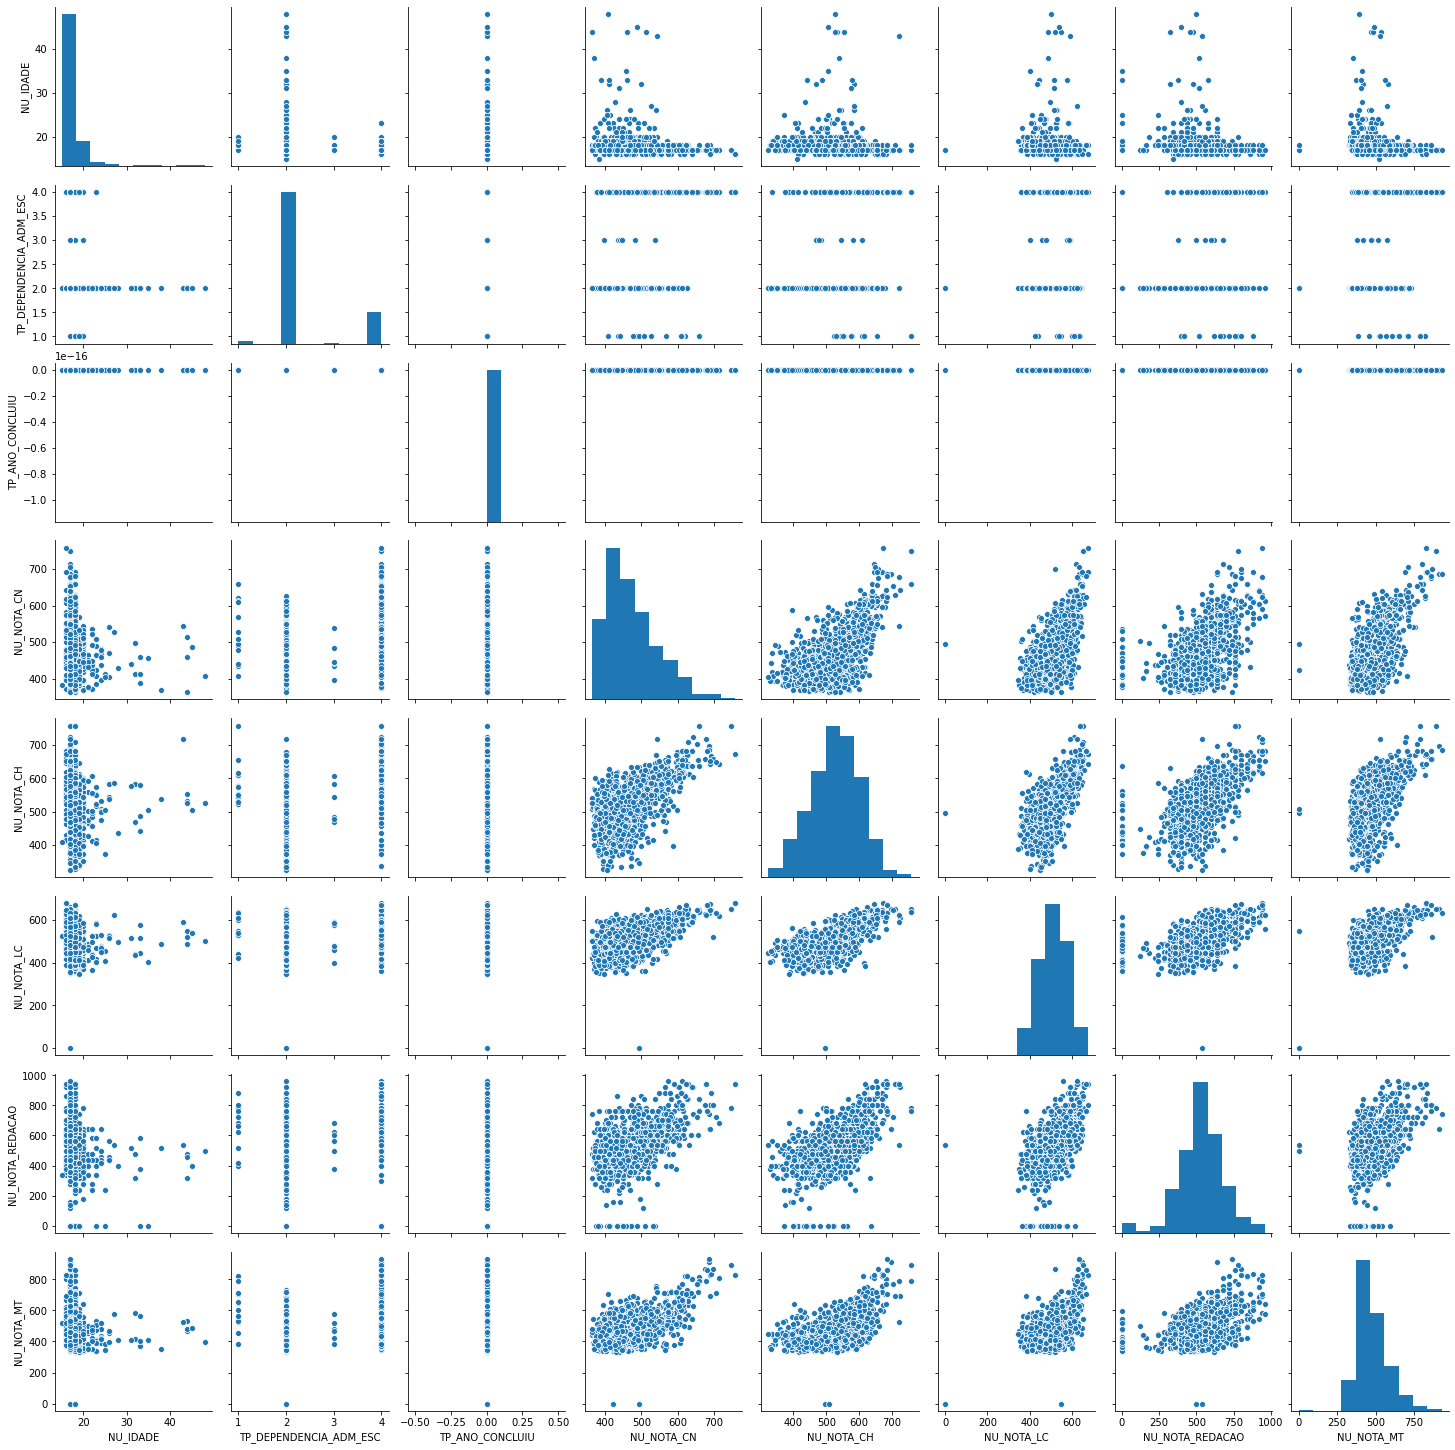

In [74]:
sns.pairplot(df_train[variables].dropna().sample(n=1000))

In [189]:
df_train[variables].isnull().sum()

NU_IDADE              0
TP_ANO_CONCLUIU       0
NU_NOTA_CN         3389
NU_NOTA_CH         3389
NU_NOTA_LC         3597
NU_NOTA_REDACAO    3597
dtype: int64

In [190]:
df_plot = df_train[variables].dropna()

In [77]:
adm_esc_dict = {
    1: 'Federal',
    2: 'Estadual',
    3: 'Municipal',
    4: 'Privada'
}

In [78]:
df_plot['TP_DEPENDENCIA_ADM_ESC'].replace(adm_esc_dict, inplace=True)

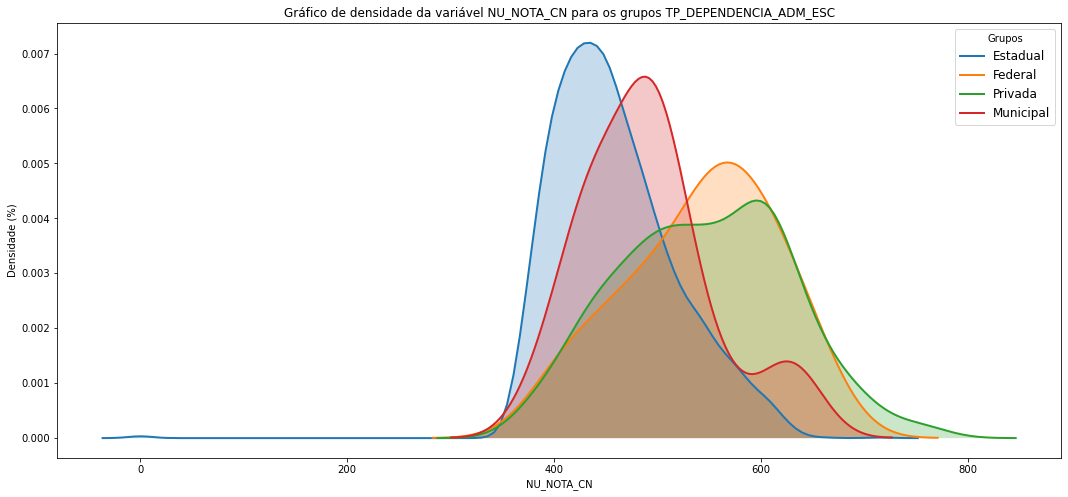

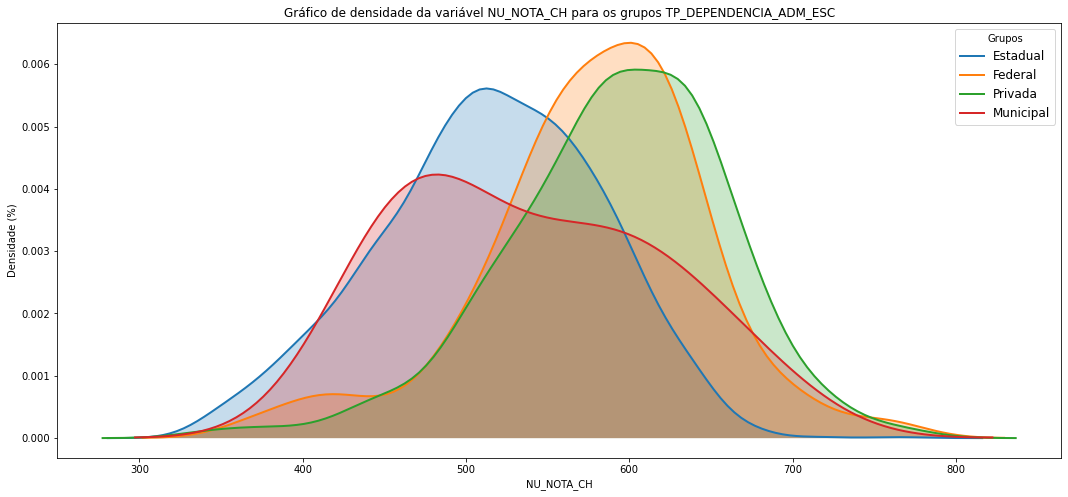

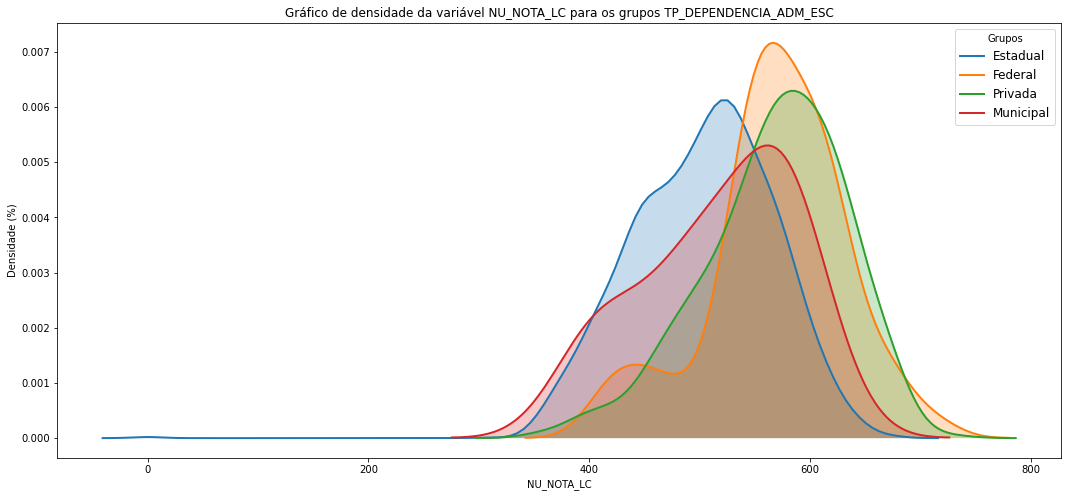

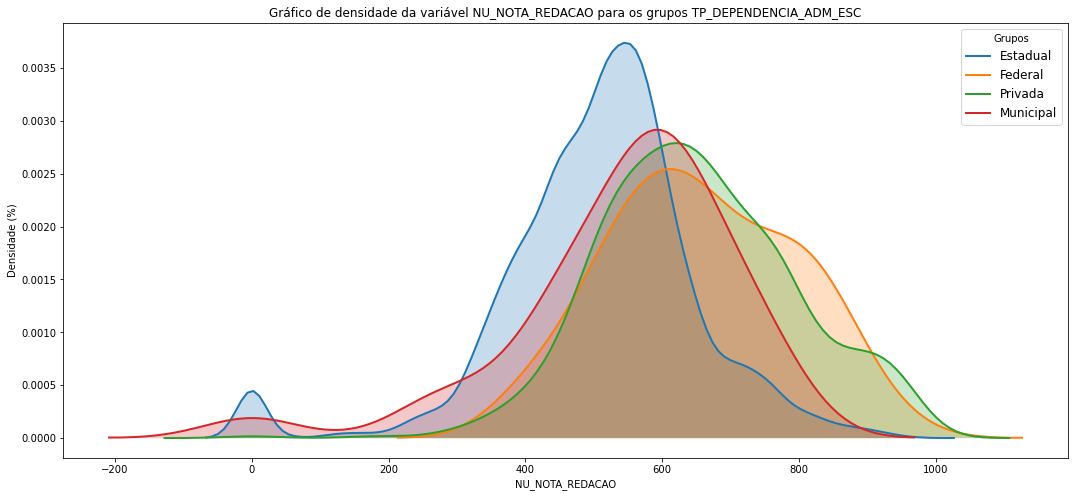

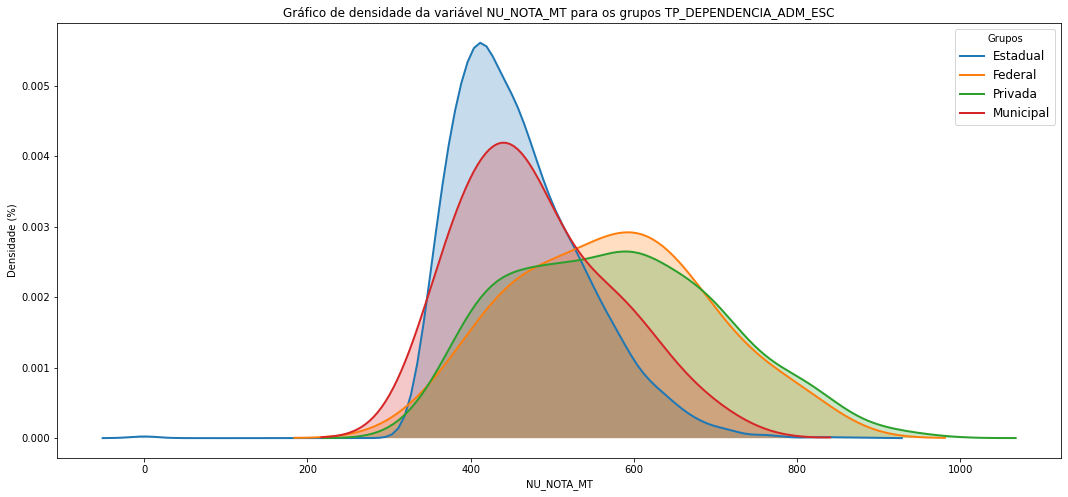

In [79]:
field = 'TP_DEPENDENCIA_ADM_ESC'
mylabels =  df_plot[field].unique()
var_plots = df_plot.select_dtypes(include=["float64", "float32"]).columns

for variable in var_plots:
    # Iterate through the five airlines
    try:
        plt.figure(figsize=(18,8))
        for mylabel in mylabels:
            # Subset to the airline
            subset = df_plot[df_plot[field] == mylabel]
            # Draw the density plot
            sns.distplot(subset[variable], hist = False, kde = True, bins=5,
                         kde_kws = {'shade' : True, 'linewidth': 2},
                         label = mylabel)

        # Plot formatting
        plt.legend(prop={'size': 12}, title = 'Grupos')
        plt.title('Gráfico de densidade da variável {variavel} para os grupos {grupos}'.format(variavel=variable, grupos=field))
        plt.xlabel('{variavel}'.format(variavel=variable))
        plt.ylabel('Densidade (%)')
        plt.plot()
    except:
        print(variable)
        pass

# Modelling

In [191]:
variables = ['NU_IDADE', 'TP_ANO_CONCLUIU', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_REDACAO', 'NU_NOTA_MT']

In [192]:
df_train = df_train[variables]

In [193]:
df_train.dropna(inplace=True)

In [194]:
exp_reg = setup(df_train, target = 'NU_NOTA_MT', train_size=0.8, transformation=False, normalize=False, remove_multicollinearity=True, transform_target=False, remove_outliers=True
                ,polynomial_features=True)

 
Setup Succesfully Completed!


,Description,Value
0,session_id,5255
1,Transform Target,False
2,Transform Target Method,None
3,Original Data,"(10097, 7)"
4,Missing Values,False
5,Numeric Features,5
6,Categorical Features,1
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


In [195]:
compare_models(blacklist = ['tr', 'lar'], fold = 10,  round = 4,  sort = 'MSE', turbo = True)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extreme Gradient Boosting,57.666400,5315.959900,72.896300,0.420000,0.182300,0.121300
1,Gradient Boosting Regressor,57.714300,5324.620400,72.956900,0.419100,0.182500,0.121400
2,CatBoost Regressor,58.102900,5402.930100,73.491800,0.410600,0.183100,0.122100
3,Light Gradient Boosting Machine,58.828900,5545.401600,74.454400,0.395000,0.184700,0.123500
4,Random Forest,59.558600,5676.868000,75.329000,0.380800,0.186600,0.125500
5,Lasso Regression,59.944600,5706.705300,75.526700,0.377600,0.186300,0.125900
6,Elastic Net,59.945000,5706.832600,75.527600,0.377600,0.186300,0.125900
7,Bayesian Ridge,59.944600,5706.840500,75.527600,0.377600,0.186300,0.125900
8,Ridge Regression,59.991800,5712.690800,75.566700,0.377000,0.186300,0.126000
9,Linear Regression,59.992600,5712.942800,75.568400,0.377000,0.186300,0.126000


In [208]:
tuned_lightgbm = tune_model('lightgbm', optimize='mse', n_iter=200)

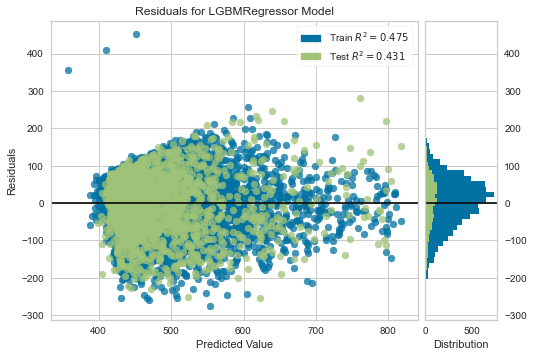

In [197]:
plot_model(tuned_lightgbm, 'residuals')

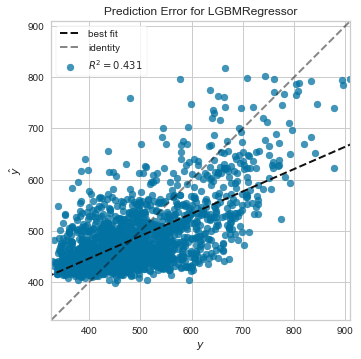

In [198]:
plot_model(tuned_lightgbm, 'error')

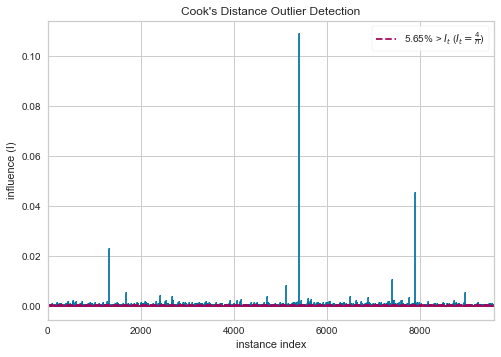

In [199]:
plot_model(tuned_lightgbm, 'cooks')

In [200]:
# plot_model(tuned_lightgbm, 'rfe')

In [201]:
# plot_model(tuned_lightgbm, 'learning')

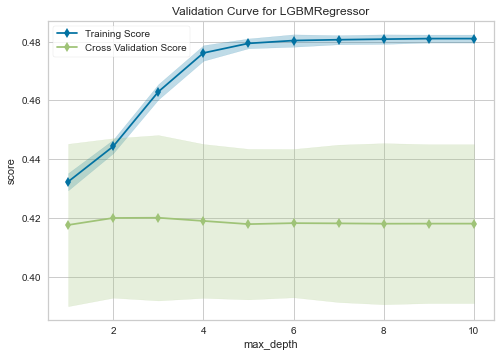

In [202]:
plot_model(tuned_lightgbm, 'vc')

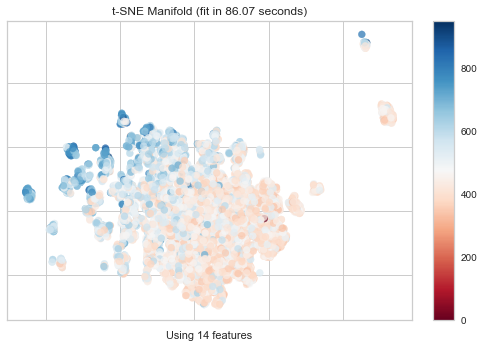

In [203]:
plot_model(tuned_lightgbm, 'manifold')

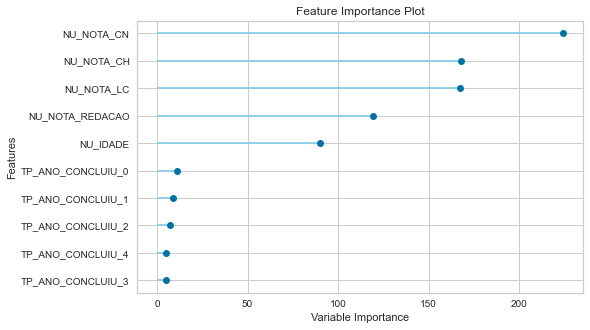

In [204]:
plot_model(tuned_lightgbm, 'feature')

In [209]:
plot_model(tuned_lightgbm, 'parameter')

,Parameters
boosting_type,gbdt
class_weight,None
colsample_bytree,1.0000
importance_type,split
learning_rate,0.1000
max_depth,40
min_child_samples,20
min_child_weight,0.0010
min_split_gain,0.1000
n_estimators,90


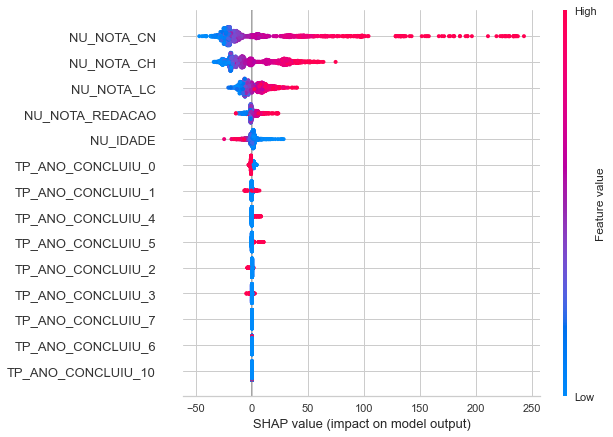

In [206]:
interpret_model(tuned_lightgbm)

# Ensembles

In [210]:
ensembled_tuned_lightgbm = ensemble_model(tuned_lightgbm)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,59.8189,5739.2466,75.7578,0.4154,0.2670,0.1257
1,56.3631,5149.0683,71.7570,0.4413,0.1462,0.1187
2,57.1400,5280.9260,72.6700,0.4527,0.1482,0.1214
3,59.1360,5510.0972,74.2300,0.4511,0.2629,0.1232
4,57.8182,5285.1878,72.6993,0.4189,0.1480,0.1212
5,55.7844,4974.0283,70.5268,0.4201,0.1445,0.1180
6,57.9393,5206.7729,72.1580,0.4115,0.1474,0.1225
7,57.6135,5388.1110,73.4038,0.3691,0.1473,0.1198
8,57.4210,5424.2129,73.6493,0.4272,0.2633,0.1201
9,57.1509,5211.1926,72.1886,0.3924,0.1471,0.1198


In [211]:
final_model = finalize_model(ensembled_tuned_lightgbm)

In [214]:
save_model(final_model, '../models/bagging_lgbm_model_20200528')


save_experiment(experiment_name="../reports/exp_20200528")

Transformation Pipeline and Model Succesfully Saved
Experiment Succesfully Saved


# Predictions

In [ ]:
variables.remove('NU_NOTA_MT')

In [219]:
df_test[variables]

,NU_IDADE,TP_ANO_CONCLUIU,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_REDACAO
0,22,5,464.8000,443.5000,431.8000,420.0000
1,26,8,391.1000,491.1000,548.0000,580.0000
2,21,0,595.9000,622.7000,613.6000,320.0000
3,27,8,nan,nan,nan,nan
4,18,0,592.9000,492.6000,571.4000,320.0000
...,...,...,...,...,...,...
4571,17,0,398.3000,558.2000,511.6000,500.0000
4572,17,0,427.6000,579.7000,471.1000,520.0000
4573,19,2,639.2000,643.8000,604.9000,640.0000
4574,17,0,427.1000,467.9000,540.2000,520.0000


In [221]:
preds = predict_model(final_model, data=df_test[variables], platform=None, authentication=None, round=4)

0       False
1       False
2       False
3        True
4       False
        ...  
4571    False
4572    False
4573    False
4574    False
4575     True
Name: NU_NOTA_CH, Length: 4576, dtype: bool

In [224]:
preds['Label'] = np.where(preds['NU_NOTA_CH'].isnull(), 0, preds['Label'])
preds

,NU_IDADE,TP_ANO_CONCLUIU,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_REDACAO,Label
0,22,5,464.8000,443.5000,431.8000,420.0000,435.6788
1,26,8,391.1000,491.1000,548.0000,580.0000,451.0277
2,21,0,595.9000,622.7000,613.6000,320.0000,590.9515
3,27,8,nan,nan,nan,nan,0.0000
4,18,0,592.9000,492.6000,571.4000,320.0000,540.9675
...,...,...,...,...,...,...,...
4571,17,0,398.3000,558.2000,511.6000,500.0000,452.9112
4572,17,0,427.6000,579.7000,471.1000,520.0000,475.8068
4573,19,2,639.2000,643.8000,604.9000,640.0000,663.5045
4574,17,0,427.1000,467.9000,540.2000,520.0000,450.8049


In [227]:
df_test['NU_NOTA_MT'] = preds['Label']
df_test

,NU_INSCRICAO,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,...,Q001,Q002,Q006,Q024,Q025,Q026,Q027,Q047,Label,NU_NOTA_MT
0,73ff9fcc02f0a99919906c942c2e1a1042cdcf98,41,PR,22,F,3,1,1,5,1,...,B,A,C,A,A,C,C,A,435.6788,435.6788
1,71a95f9f1b91a82c65ad94abbdf9f54e6066f968,21,MA,26,F,3,1,1,8,1,...,E,B,C,B,B,B,F,A,451.0277,451.0277
2,b38a03232f43b11c9d0788abaf060f7366053b6d,23,CE,21,M,1,1,2,0,2,...,E,E,D,B,B,A,NaN,A,590.9515,590.9515
3,70b682d9a3636be23f6120fa9d6b164eb3c6002d,15,PA,27,F,3,1,1,8,1,...,H,E,G,B,B,A,NaN,A,0.0000,0.0000
4,715494628a50142ce8cb17191cfe6d0f3cae0934,41,PR,18,M,1,1,2,0,2,...,D,H,H,C,B,A,NaN,A,540.9675,540.9675
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4571,dac0f22429c7f8e3931d0abaf5dfc8e5c772a48b,41,PR,17,F,1,1,2,0,2,...,E,E,D,A,B,A,NaN,A,452.9112,452.9112
4572,a75fa8770257e7c9368d059fe53d9ef431f4bdef,35,SP,17,M,2,1,2,0,2,...,C,C,C,A,A,A,NaN,A,475.8068,475.8068
4573,655fa6306720ff16e825903b5422a46608a77545,35,SP,19,M,1,1,1,2,1,...,D,F,D,B,B,A,NaN,D,663.5045,663.5045
4574,1f4bc3e3d56212d500625bfe8ac78ccff4362293,52,GO,17,M,2,2,3,0,1,...,C,E,C,A,A,A,NaN,A,450.8049,450.8049


In [228]:
df_test[['NU_INSCRICAO', 'NU_NOTA_MT']].to_csv("../data/processed/answer.csv", index=False)

# Bayesian Optimization

In [256]:
def create_lgb_dataset(df, variables, target, test_size=0.2, random_state=42):

    # Read in data and separate into training and testing sets
    train, test, train_labels, test_labels = train_test_split(df[variables].drop(columns=target, axis=1),
                                                        df[target], test_size=test_size, random_state=random_state)

    # Extract the labels and format properly
    train_labels = np.array(train_labels.astype(np.int32)).reshape((-1,))
    test_labels = np.array(test_labels.astype(np.int32)).reshape((-1,))

    # Convert to numpy array for splitting in cross validation
    train_features = np.array(train)
    test_features = np.array(test)
    train_labels = train_labels[:]
    test_labels = test_labels[:]

    print('Train shape: ', train.shape)
    print('Test shape: ', test.shape)
    return train_features, test_features, train_labels, test_labels

In [257]:
train_features, test_features, train_labels, test_labels = create_lgb_dataset(df_train, variables, target='NU_NOTA_MT')

Train shape:  (8077, 6)
Test shape:  (2020, 6)


In [258]:
train_set = lgb.Dataset(train_features, label = train_labels)
test_set = lgb.Dataset(test_features, label = test_labels)

In [280]:
def objective(params, metrics = 'mse', n_folds=10, logging_name='LGBMRegressor.csv'):
    """Objective function for Gradient Boosting Machine Hyperparameter Optimization"""
    
    # Keep track of evals
    global ITERATION
    
    ITERATION += 1
    
    # Retrieve the subsample if present otherwise set to 1.0
    subsample = params['boosting_type'].get('subsample', 1.0)
    
    # Extract the boosting type
    params['boosting_type'] = params['boosting_type']['boosting_type']
    params['subsample'] = subsample
    
    # Make sure parameters that need to be integers are integers
    for parameter_name in ['num_leaves', 'subsample_for_bin', 'min_child_samples']:
        params[parameter_name] = int(params[parameter_name])
    
    start = timer()
    
    # Perform n_folds cross validation
    cv_results = lgb.cv(params, train_set, num_boost_round = 10000, nfold = n_folds, 
                        early_stopping_rounds = 100, metrics = metrics, seed = 50)
    
    run_time = timer() - start
    
    # Extract the best score
    best_score = np.max(cv_results['l2-mean'])
    
    # Loss must be minimized
    loss = 1 - best_score
    
    # Boosting rounds that returned the highest cv score
    n_estimators = int(np.argmax(cv_results['l2-mean']) + 1)

    # Write to the csv file ('a' means append)
    of_connection = open(out_file, 'a')
    writer = csv.writer(of_connection)
    writer.writerow([loss, params, ITERATION, n_estimators, run_time])
    
    # Dictionary with information for evaluation
    return {'loss': loss, 'params': params, 'iteration': ITERATION,
            'estimators': n_estimators, 
            'train_time': run_time, 'status': STATUS_OK}

In [281]:
# Define the search space
space = {
    'objective' : 'mean_squared_error',
    'boosting_type': hp.choice('boosting_type', [{'boosting_type': 'gbdt', 'subsample': hp.uniform('gdbt_subsample', 0.5, 1)}, 
                                                 {'boosting_type': 'dart', 'subsample': hp.uniform('dart_subsample', 0.5, 1)},
                                                 {'boosting_type': 'goss', 'subsample': 1.0}]),
    'num_leaves': hp.quniform('num_leaves', 30, 150, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
    'subsample_for_bin': hp.quniform('subsample_for_bin', 20000, 300000, 20000),
    'min_child_samples': hp.quniform('min_child_samples', 20, 500, 5),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 1.0)
}

In [286]:
# Run optimization
best = fmin(fn = objective, space = space, algo = tpe.suggest, 
            max_evals = 10, trials = bayes_trials, rstate = np.random.RandomState(34))

 70%|████████████████████████████████████████████████████▌                      | 7/10 [00:00<?, ?trial/s, best loss=?]
